### Logistic Regression implementation

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

class OurLogisticRegression:
    """ Logistic Regression model using numpy"""

    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True):
        """
        Model constructor
        Inputs:
        lr -> learning rate
        num_iter -> number of iterations in model
        """
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept

    def get_params(self, deep=True):
        """
        Get the model hyperparameters
        """
        return {"lr": self.lr, "num_iter": self.num_iter}
    
    def set_params(self, **params):
        """
        Set the model hyperparameters
        """
        for parameter, value in params.items():
            setattr(self, parameter, value)
        return self
       

    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def __sigmoid(self, z):
        """
        Activation function sigmoid
        """
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        """
        Training function that changes the w and b values progressively using
        descend gradient
        """
        if self.fit_intercept:
            X = self.__add_intercept(X)

        # weights initialization
        self.w = np.zeros(X.shape[1])

        for i in range(self.num_iter):
            z = np.dot(X, self.w)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h-y)) / y.size
            self.w -= self.lr * gradient

    def predict_prob(self, X):
        """
        Predict probability given by the model using sigmoid function
        """
        if self.fit_intercept:
            X = self.__add_intercept(X)

        return self.__sigmoid(np.dot(X, self.w))

    def predict(self, X, threshold=0.5):
        """
        Get the result the prediction of a set of data by comparing the threshold
        """
        return self.predict_prob(X) >= threshold
    
    def score(self, X, y):
        """
        Score the values obtained
        """
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy
    
    # model metrics

    def accurancy(self, y_pred,y_test):
        return accuracy_score(y_test, y_pred)
    
    def precision(self, y_pred,y_test):
        return precision_score(y_test, y_pred)
    
    def recall(self, y_pred,y_test):
        return recall_score(y_test, y_pred)
    
    def auc(self, y_pred,y_test):
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        return fpr, tpr, roc_auc
    
    def plot_roc(self, fpr, tpr, title):
        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('1-Especificity')
        plt.ylabel('Sensibility')
        plt.title(title)
        plt.show()

### Red Wine Dataset

In [2]:
# read the dataset
df_cancer = pd.read_csv('datasets/Cancer_Data.csv')

# make sure that there are no null values that can affect the models
mask = df_cancer.isnull()
#print(mask.sum())

# delete unnecesary or null columns
df_cancer = df_cancer.drop(columns=['id', 'Unnamed: 32'])

# visualizing the values of each feature and the comparison to the output
"""
for col in df_cancer.columns[:-1]:
    df_cancer.plot(x=col, y='diagnosis', kind='scatter', figsize=(8, 5))
plt.show()
"""

# Data preprocessing - outliner treatment
# eliminating data that is outside the normal values in each feature
features = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']
l_limit_perc = 0
h_limit_perc = 0.99

for feature in features:
    low_limit = df_cancer[feature].quantile(l_limit_perc)
    high_limit = df_cancer[feature].quantile(h_limit_perc)
    df_cancer = df_cancer.loc[(df_cancer[feature] >= low_limit) & (df_cancer[feature] <= high_limit)]

# visualizing the new values
# (not ploting to avoid data overload in the notebook)
"""
for col in df_cancer.columns[:-1]:
    df_cancer.plot(x=col, y='diagnosis', kind='scatter', figsize=(8, 5))
plt.show()
"""

# feature engineering
# normalization of the data
for feature in features:
    df_cancer[feature] = (df_cancer[feature]-df_cancer[feature].mean())/df_cancer[feature].std()

# change value of output to 0 and 1
# 0 -> B
# 1 -> M
df_cancer.loc[df_cancer['diagnosis'] == 'B', 'diagnosis'] = 0
df_cancer.loc[df_cancer['diagnosis'] == 'M', 'diagnosis'] = 1

# Define training and test sets using stratify
X0 = df_cancer.loc[df_cancer['diagnosis'] == 0, features]
Y0 = df_cancer.loc[df_cancer['diagnosis'] == 0, 'diagnosis']

X1 = df_cancer.loc[df_cancer['diagnosis'] == 1, features]
Y1 = df_cancer.loc[df_cancer['diagnosis'] == 1, 'diagnosis']

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, Y0, test_size=0.4, random_state=40)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size=0.4, random_state=40)

X_train = pd.concat([X0_train, X1_train], axis= 0)
y_train = pd.concat([y0_train, y1_train], axis= 0)

df_cancer.head(10)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
4,1,2.693059,-1.066016,2.804659,3.153238,0.570109,1.450598,2.910960,2.638141,0.316256,...,2.292792,-1.448454,2.441541,2.564984,0.495124,0.049978,1.478654,1.462551,-0.956138,-0.161961
6,1,1.907110,0.414335,1.922237,2.044515,0.108663,0.738427,1.135330,1.478698,0.245176,...,2.395693,0.584415,2.486269,2.657834,0.844900,0.590506,1.319582,2.103252,0.706127,0.437678
10,1,1.047960,1.269999,0.960112,0.999640,-0.914330,-0.527622,-0.523937,-0.081384,-1.015293,...,1.278912,1.734956,1.171264,1.292044,-0.497623,-0.462804,-0.392655,0.152977,0.432650,0.510677
11,1,0.955495,-0.134235,1.011350,0.927163,0.309681,1.342875,0.861388,1.174870,0.472630,...,1.651173,0.514125,1.739310,1.738322,0.608287,3.707276,1.452879,1.848641,2.439734,2.273095
13,1,0.982464,1.456356,1.017043,0.934497,-0.755632,0.475103,0.858057,0.699614,0.496323,...,0.567683,0.584415,0.643472,0.472871,-0.754811,-0.079502,0.242898,0.406544,0.102099,-1.370799
16,1,0.531699,0.453706,0.506946,0.510853,0.437453,-0.368730,0.328699,0.659435,-0.740454,...,1.242594,1.180033,1.153372,1.256103,0.958063,-0.133966,0.678874,1.429160,0.625273,0.305583
17,1,1.090339,0.598067,1.267537,1.003954,1.929216,3.527266,2.373900,2.580743,1.998461,...,1.814604,1.291017,1.752728,1.786244,2.629788,2.293272,2.056028,2.397515,2.235220,3.089994
19,0,0.092492,-1.060767,0.092492,0.000926,0.365836,-0.090744,0.176532,0.476526,0.676390,...,0.044098,-0.969370,0.093317,-0.022228,0.834613,-0.234672,0.292976,0.759242,0.501614,-0.526090
20,0,-0.084732,-0.706427,-0.011690,-0.198817,1.156071,1.277044,-0.259778,-0.162890,1.064956,...,-0.140519,-0.741852,-0.068151,-0.263937,0.176211,0.796030,-0.075247,-0.408836,0.993872,0.276905
21,0,-1.462455,-1.564716,-1.451461,-1.260516,0.741014,-0.580586,-0.595336,-0.558554,0.344687,...,-1.432837,-1.635279,-1.452932,-1.209207,0.237936,-0.876935,-0.814123,-0.629220,-0.751625,-0.079402


### Train model and test results

    Amount of tests          Model  Accurancy  Precision    Recall       Auc
0                 3      Our model   0.833333   1.000000  0.666667  0.833333
1                 3  Sklearn model   0.833333   1.000000  0.666667  0.833333
2                 9      Our model   0.833333   0.800000  0.888889  0.833333
3                 9  Sklearn model   0.833333   1.000000  0.666667  0.833333
4                19      Our model   0.921053   0.900000  0.947368  0.921053
5                19  Sklearn model   0.894737   1.000000  0.789474  0.894737
6                28      Our model   0.910714   0.870968  0.964286  0.910714
7                28  Sklearn model   0.910714   1.000000  0.821429  0.910714
8                34      Our model   0.911765   0.868421  0.970588  0.911765
9                34  Sklearn model   0.926471   1.000000  0.852941  0.926471
10               38      Our model   0.907895   0.860465  0.973684  0.907895
11               38  Sklearn model   0.921053   1.000000  0.842105  0.921053

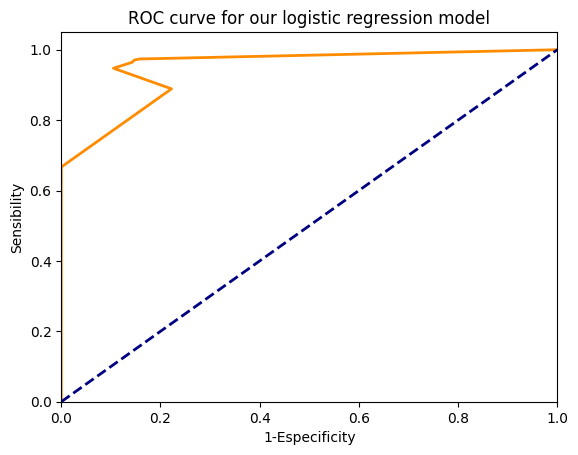

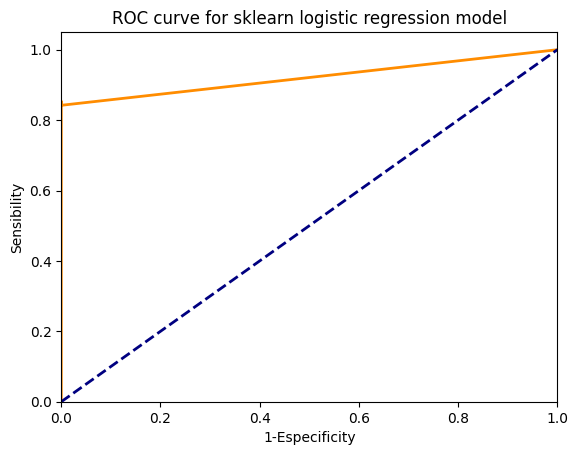

In [10]:
# initial variables
test_percentages = [0.1, 0.25, 0.50, 0.75, 0.9, 1]
y_tests = {'our_model': [], 'sklearn_model': []}
y_preds = {'our_model': [], 'sklearn_model': []}
accurancies = {'our_model': [], 'sklearn_model': []}
precisions = {'our_model': [], 'sklearn_model': []}
recalls = {'our_model': [], 'sklearn_model': []}
num_rows = min(X0_test.shape[0], X1_test.shape[0])

# Get the bes model hyperparameters
#model = OurLogisticRegression()
#param_grid = {'lr': [0.001, 0.05, 0.01],
#              'num_iter': [100, 1000, 10000]}
#grid_search = GridSearchCV(model, param_grid, cv=5)
#
#grid_search.fit(X_train, y_train.astype(int))
#
#print("Best hyperparameters: ", grid_search.best_params_)

# Instantiate model with the best hyperparameters
model = OurLogisticRegression(lr=0.001, num_iter=100)
model.fit(X_train, y_train.astype(int))

# Instantiate sklearn logistic regression model
model_sklearn = LogisticRegression()
model_sklearn.fit(X_train, y_train.astype(int))

# get testing metrics by using different amount of tests
for test_percentage in test_percentages:

    # get the amount of data needed for each percentage
    n_tests = int(num_rows * test_percentage)
    X0_test_i = X0_test.iloc[:n_tests, :]
    X1_test_i = X1_test.iloc[:n_tests, :]
    y0_test_i = y0_test.iloc[:n_tests]
    y1_test_i = y1_test.iloc[:n_tests]

    X_test_i = pd.concat([X0_test_i, X1_test_i], axis= 0)
    y_test_i = pd.concat([y0_test_i, y1_test_i], axis= 0)
    y_tests['our_model'].append(y_test_i)
    y_tests['sklearn_model'].append(y_test_i)

    ## Predictions for out model
    # predict probabilities for test set
    probs = model.predict_prob(X_test_i)

    # predict classes for test set
    y_pred_i = model.predict(X_test_i, 0.5)
    y_preds['our_model'].append(y_pred_i)

    # get the metrics
    accurancies['our_model'].append(model.accurancy(y_pred_i, y_test_i.astype(int)))
    precisions['our_model'].append(model.precision(y_pred_i, y_test_i.astype(int)))
    recalls['our_model'].append(model.recall(y_pred_i, y_test_i.astype(int)))

    ## Predictions for sklearn model
    y_pred_i = model_sklearn.predict(X_test_i)
    y_preds['sklearn_model'].append(y_pred_i)

    # get the metrics
    accurancies['sklearn_model'].append(model.accurancy(y_pred_i, y_test_i.astype(int)))
    precisions['sklearn_model'].append(model.precision(y_pred_i, y_test_i.astype(int)))
    recalls['sklearn_model'].append(model.recall(y_pred_i, y_test_i.astype(int)))

# draw ROC curve
fpr_model = np.array([0., 1.])
tpr_model = np.array([0., 1.])
fpr_sk = np.array([0., 1.])
tpr_sk = np.array([0., 1.])
aucs = {'our_model': [], 'sklearn_model': []}
for i in range(len(test_percentages)):
    fpr_i, tpr_i, auc_i = model.auc(y_preds['sklearn_model'][i], y_tests['sklearn_model'][i].astype(int))
    fpr_sk = np.insert(fpr_sk, -1, fpr_i[1])
    tpr_sk = np.insert(tpr_sk, -1, tpr_i[1])
    aucs['sklearn_model'].append(auc_i)

    fpr_i, tpr_i, auc_i = model.auc(y_preds['our_model'][i], y_tests['our_model'][i].astype(int))
    fpr_model = np.insert(fpr_model, -1, fpr_i[1])
    tpr_model = np.insert(tpr_model, -1, tpr_i[1])
    aucs['our_model'].append(auc_i)

    

# display test metric results
title_row = ['Amount of tests','Model', 'Accurancy', 'Precision', 'Recall', 'Auc']
df_results = pd.DataFrame(columns=title_row)

for i, test_percentage in enumerate(test_percentages):
    row = [int(test_percentage*num_rows), 'Our model', accurancies['our_model'][i], precisions['our_model'][i], recalls['our_model'][i], aucs['our_model'][i]]
    df_results.loc[len(df_results)] = row
    row = [int(test_percentage*num_rows), 'Sklearn model', accurancies['sklearn_model'][i], precisions['sklearn_model'][i], recalls['sklearn_model'][i], aucs['sklearn_model'][i]]
    df_results.loc[len(df_results)] = row

print(df_results)
model.plot_roc(fpr_model, tpr_model, 'ROC curve for our logistic regression model')
model.plot_roc(fpr_sk, tpr_sk, 'ROC curve for sklearn logistic regression model')
